In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
import os
import sys

from importlib import reload
import src.utils.utils
reload(src.utils.utils)
from src.utils.utils import top_n_by_interval, top_n_total_revenue, top_n_average_rating

In [2]:
data_folder = './data/'
pickle_folder = data_folder + 'pickle/'
imdb_folder = data_folder + 'IMDB/'
cmu_folder = data_folder + 'CMU/'

with open(pickle_folder + 'movies_clean.p', 'rb') as f:
    movie_data = pickle.load(f)

In [3]:
df_mod = movie_data.copy()

In [4]:
# Drop the Movie_box_office column since it has a lot of missing values
df_mod.drop(columns=['Movie_box_office_revenue'], inplace=True)

In [5]:
# Convert the Year_interval column to a categorical column
categorical_columns = ['Year_Interval']
other_columns = [col for col in df_mod.columns if col not in categorical_columns]
year_interval = pd.get_dummies(df_mod[categorical_columns])
df_mod_encoded = pd.concat([df_mod[other_columns], year_interval], axis=1)
df_mod_encoded

,Wikipedia_movie_ID,Movie_name,Year,nb_of_Genres,Genre_Action,Genre_Action/Adventure,Genre_Adventure,Genre_Animation,Genre_Biographical film,Genre_Biography,...,Country_Other,Country_United Kingdom,Country_United States of America,averageRating,numVotes,Year_Interval_1915-1935,Year_Interval_1935-1955,Year_Interval_1955-1975,Year_Interval_1975-1995,Year_Interval_1995-2015
0,3217,Army of Darkness,1992,12,True,True,False,False,False,False,...,False,False,True,7.4,197717.0,False,False,False,True,False
1,3333,The Birth of a Nation,1915,7,False,False,False,False,False,False,...,False,False,True,6.1,26681.0,True,False,False,False,False
2,3746,Blade Runner,1982,12,False,False,False,False,False,False,...,False,False,True,8.1,835060.0,False,False,False,True,False
3,3837,Blazing Saddles,1974,3,False,False,False,False,False,False,...,False,False,True,7.7,155432.0,False,False,True,False,False
4,3947,Blue Velvet,1986,3,False,False,False,False,False,False,...,False,False,True,7.7,219742.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34784,36674310,Mystery of Marie Roget,1942,1,False,False,False,False,False,False,...,False,False,True,5.9,371.0,False,True,False,False,False
34785,36683360,2016: Obama's America,2012,1,False,False,False,False,False,False,...,False,False,True,4.8,11049.0,False,False,False,False,True
34786,36814246,Eraserhead,1977,10,False,False,False,False,False,False,...,False,False,True,7.3,130107.0,False,False,False,True,False
34788,36929245,Before Midnight,2013,2,False,False,False,False,False,False,...,False,False,True,7.9,175072.0,False,False,False,False,True


In [6]:
df_mod[df_mod.isnull().any(axis=1)]

,Wikipedia_movie_ID,Movie_name,Year,Year_Interval,nb_of_Genres,Genre_Action,Genre_Action/Adventure,Genre_Adventure,Genre_Animation,Genre_Biographical film,...,Country_Germany,Country_Hong Kong,Country_India,Country_Italy,Country_Japan,Country_Other,Country_United Kingdom,Country_United States of America,averageRating,numVotes


In [7]:
# Drop the movie name and movie id columns
df_mod_encoded.drop(columns=['Movie_name', 'Wikipedia_movie_ID'], inplace=True)

In [8]:
df_mod_encoded.columns

Index(['Year', 'nb_of_Genres', 'Genre_Action', 'Genre_Action/Adventure',
       'Genre_Adventure', 'Genre_Animation', 'Genre_Biographical film',
       'Genre_Biography', 'Genre_Black comedy', 'Genre_Black-and-white',
       'Genre_Bollywood', 'Genre_Chinese Movies', 'Genre_Comedy',
       'Genre_Comedy film', 'Genre_Comedy-drama', 'Genre_Crime Fiction',
       'Genre_Crime Thriller', 'Genre_Documentary', 'Genre_Drama',
       'Genre_Family Drama', 'Genre_Family Film', 'Genre_Fantasy',
       'Genre_Film adaptation', 'Genre_Horror', 'Genre_Indie',
       'Genre_Japanese Movies', 'Genre_LGBT', 'Genre_Musical', 'Genre_Mystery',
       'Genre_Other', 'Genre_Period piece', 'Genre_Psychological thriller',
       'Genre_Romance Film', 'Genre_Romantic comedy', 'Genre_Romantic drama',
       'Genre_Science Fiction', 'Genre_Short Film', 'Genre_Silent film',
       'Genre_Sports', 'Genre_Thriller', 'Genre_War film', 'Genre_Western',
       'Genre_World cinema', 'nb_of_Languages', 'lang_english',

In [9]:
df_mod_encoded.dtypes

Year                       int64
nb_of_Genres               int64
Genre_Action                bool
Genre_Action/Adventure      bool
Genre_Adventure             bool
                           ...  
Year_Interval_1915-1935     bool
Year_Interval_1935-1955     bool
Year_Interval_1955-1975     bool
Year_Interval_1975-1995     bool
Year_Interval_1995-2015     bool
Length: 74, dtype: object

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define features and target
X = df_mod_encoded.drop(columns=['averageRating'])  # Exclude the target column
y = df_mod_encoded['averageRating']  # Target variable

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
feature_importances = rf.feature_importances_

# Map feature importance to feature names
importance_df_RF = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
print(importance_df_RF)

                    Feature  Importance
67                 numVotes    0.290225
0                      Year    0.165696
18              Genre_Drama    0.063016
17        Genre_Documentary    0.051634
1              nb_of_Genres    0.043984
..                      ...         ...
37        Genre_Silent film    0.000726
11     Genre_Chinese Movies    0.000700
68  Year_Interval_1915-1935    0.000570
51         lang_silent film    0.000459
56        Country_Argentina    0.000379

[73 rows x 2 columns]


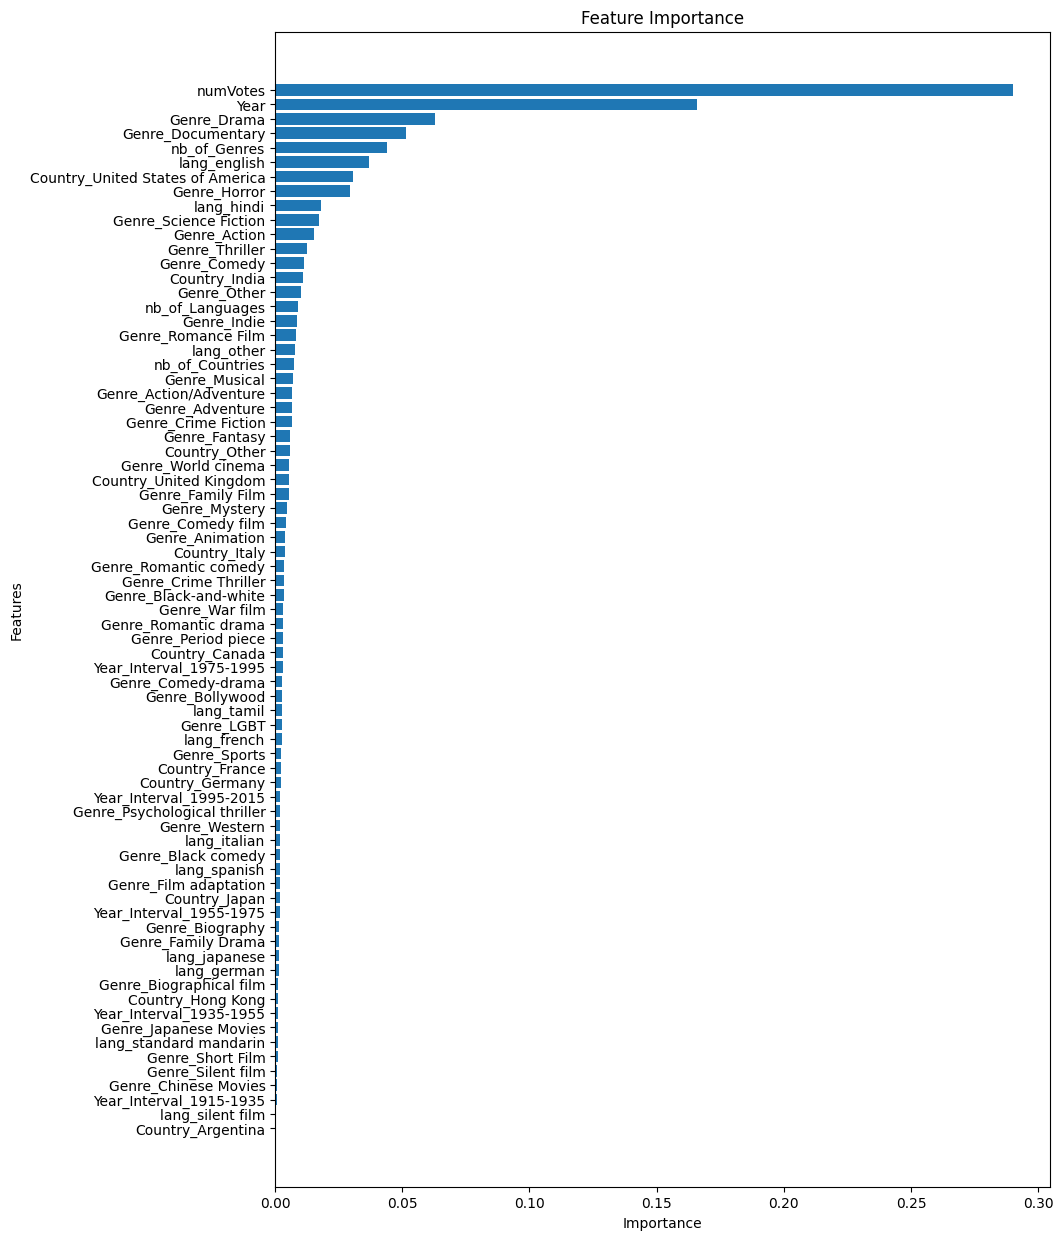

In [11]:
plt.figure(figsize=(10, 15))
plt.barh(importance_df_RF['Feature'], importance_df_RF['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Define features and target
X = df_mod_encoded.drop(columns=['averageRating'])
y = df_mod_encoded['averageRating']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

# Get feature importance
importance_df_xgb = pd.DataFrame({'Feature': X.columns, 'Importance': xgb.feature_importances_}).sort_values(by='Importance', ascending=False)
print(importance_df_xgb)

                             Feature  Importance
17                 Genre_Documentary    0.204403
44                      lang_english    0.069694
18                       Genre_Drama    0.059028
23                      Genre_Horror    0.057804
66  Country_United States of America    0.053969
..                               ...         ...
25             Genre_Japanese Movies    0.002714
6            Genre_Biographical film    0.002698
59                   Country_Germany    0.002384
68           Year_Interval_1915-1935    0.000000
72           Year_Interval_1995-2015    0.000000

[73 rows x 2 columns]


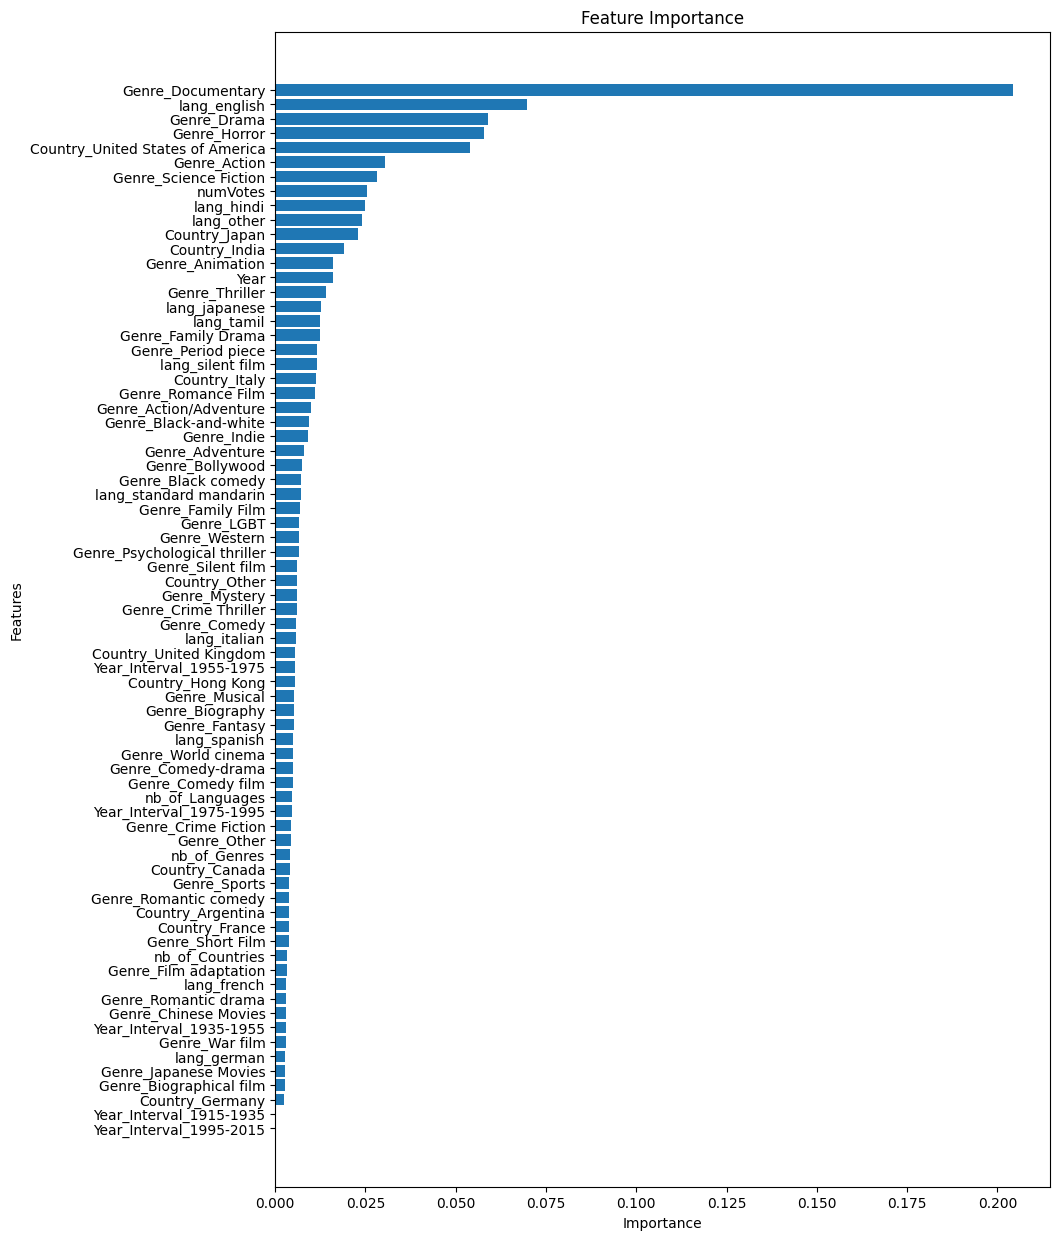

In [13]:
plt.figure(figsize=(10, 15))
plt.barh(importance_df_xgb['Feature'], importance_df_xgb['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features and target
X = df_mod_encoded.drop(columns=['averageRating'])
y = df_mod_encoded['averageRating']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train a linear regression model
lr = LinearRegression()
lr.fit(X_scaled, y)

# Get feature importance (absolute values of coefficients)
coefficients = lr.coef_
importance_df_LR = pd.DataFrame({'Feature': X.columns, 'Importance': abs(coefficients)}).sort_values(by='Importance', ascending=False)
print(importance_df_LR)

                    Feature    Importance
72  Year_Interval_1995-2015  6.373252e+11
71  Year_Interval_1975-1995  5.428849e+11
70  Year_Interval_1955-1975  4.770313e+11
69  Year_Interval_1935-1955  4.492562e+11
68  Year_Interval_1915-1935  2.815117e+11
..                      ...           ...
24              Genre_Indie  2.331185e-03
16     Genre_Crime Thriller  2.008574e-03
12             Genre_Comedy  1.930523e-03
37        Genre_Silent film  1.629783e-03
58           Country_France  1.155497e-03

[73 rows x 2 columns]


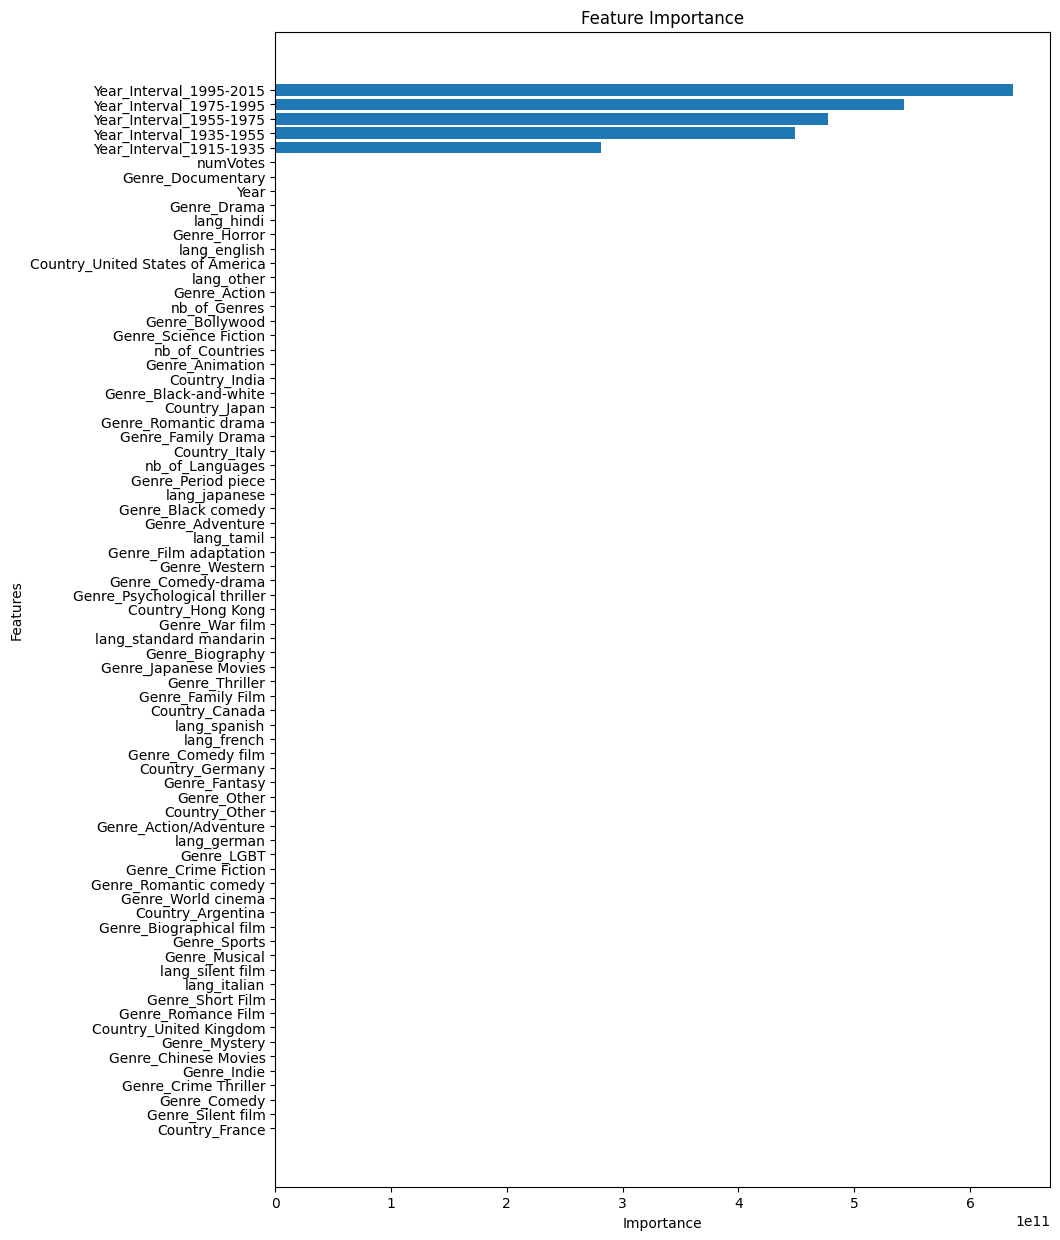

In [15]:
plt.figure(figsize=(10, 15))
plt.barh(importance_df_LR['Feature'], importance_df_LR['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()